# Potato Disease Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/plantvillagepotato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As seen above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

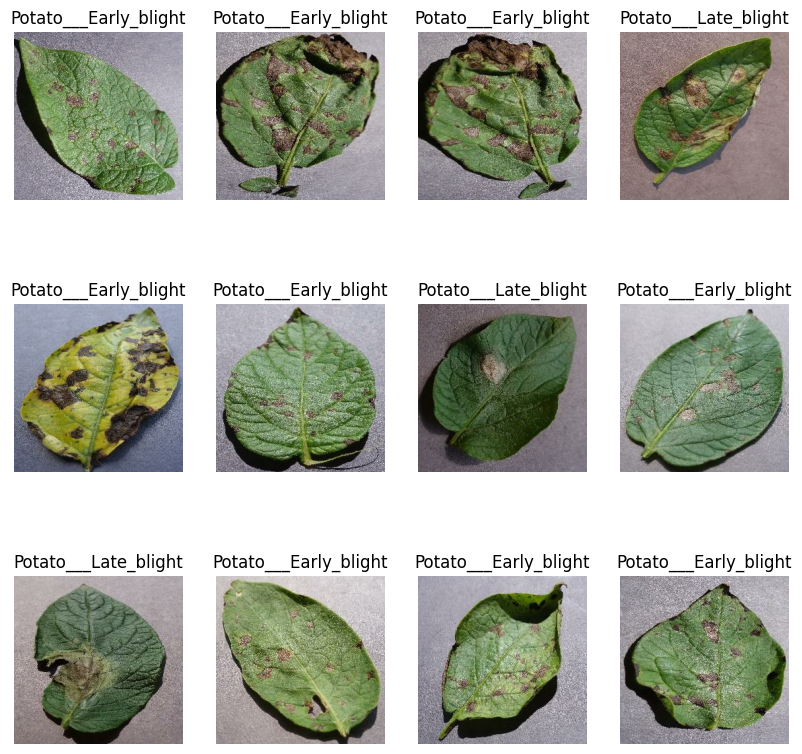

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



In [24]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential([
    base_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

29084464/29084464 [==============================] - 0s 0us/step


In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 11,232,067
Trainable params: 11,148,419
Non-trainable params: 83,648
_________________________________________________________________


### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 249s 582ms/step - loss: 1.8285 - accuracy: 0.8594 - val_loss: 1291479.2500 - val_accuracy: 0.4896
Epoch 2/20
54/54 [==============================] - 26s 477ms/step - loss: 0.1270 - accuracy: 0.9583 - val_loss: 58.6662 - val_accuracy: 0.5729
Epoch 3/20
54/54 [==============================] - 26s 471ms/step - loss: 0.0956 - accuracy: 0.9664 - val_loss: 263.4047 - val_accuracy: 0.4896
Epoch 4/20
54/54 [==============================] - 25s 457ms/step - loss: 0.1004 - accuracy: 0.9641 - val_loss: 276.6123 - val_accuracy: 0.6042
Epoch 5/20
54/54 [==============================] - 26s 467ms/step - loss: 0.0656 - accuracy: 0.9751 - val_loss: 2.2691 - val_accuracy: 0.7708
Epoch 6/20
54/54 [==============================] - 26s 472ms/step - loss: 0.0299 - accuracy: 0.9919 - val_loss: 0.0682 - val_accuracy: 0.9844
Epoch 7/20
54/54 [==============================] - 25s 467ms/step - loss: 0.0196 - accuracy: 0.9925 - val_loss: 0.0105 - val_accu

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 117ms/step - loss: 0.0105 - accuracy: 0.9961


In [29]:
scores

[0.010460379533469677, 0.99609375]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

20

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.828545093536377,
 0.12695062160491943,
 0.09558086097240448,
 0.10040351003408432,
 0.0656207874417305]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

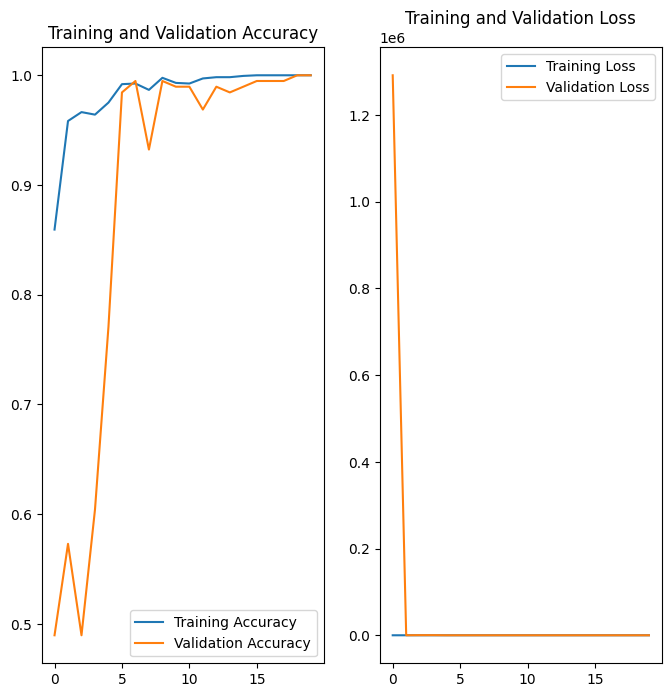

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(20), acc[:20], label='Training Accuracy')
plt.plot(range(20), val_acc[:20], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(20), loss[:20], label='Training Loss')
plt.plot(range(20), val_loss[:20], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


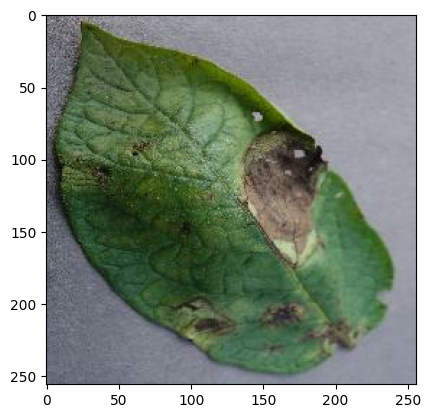

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 30ms/step


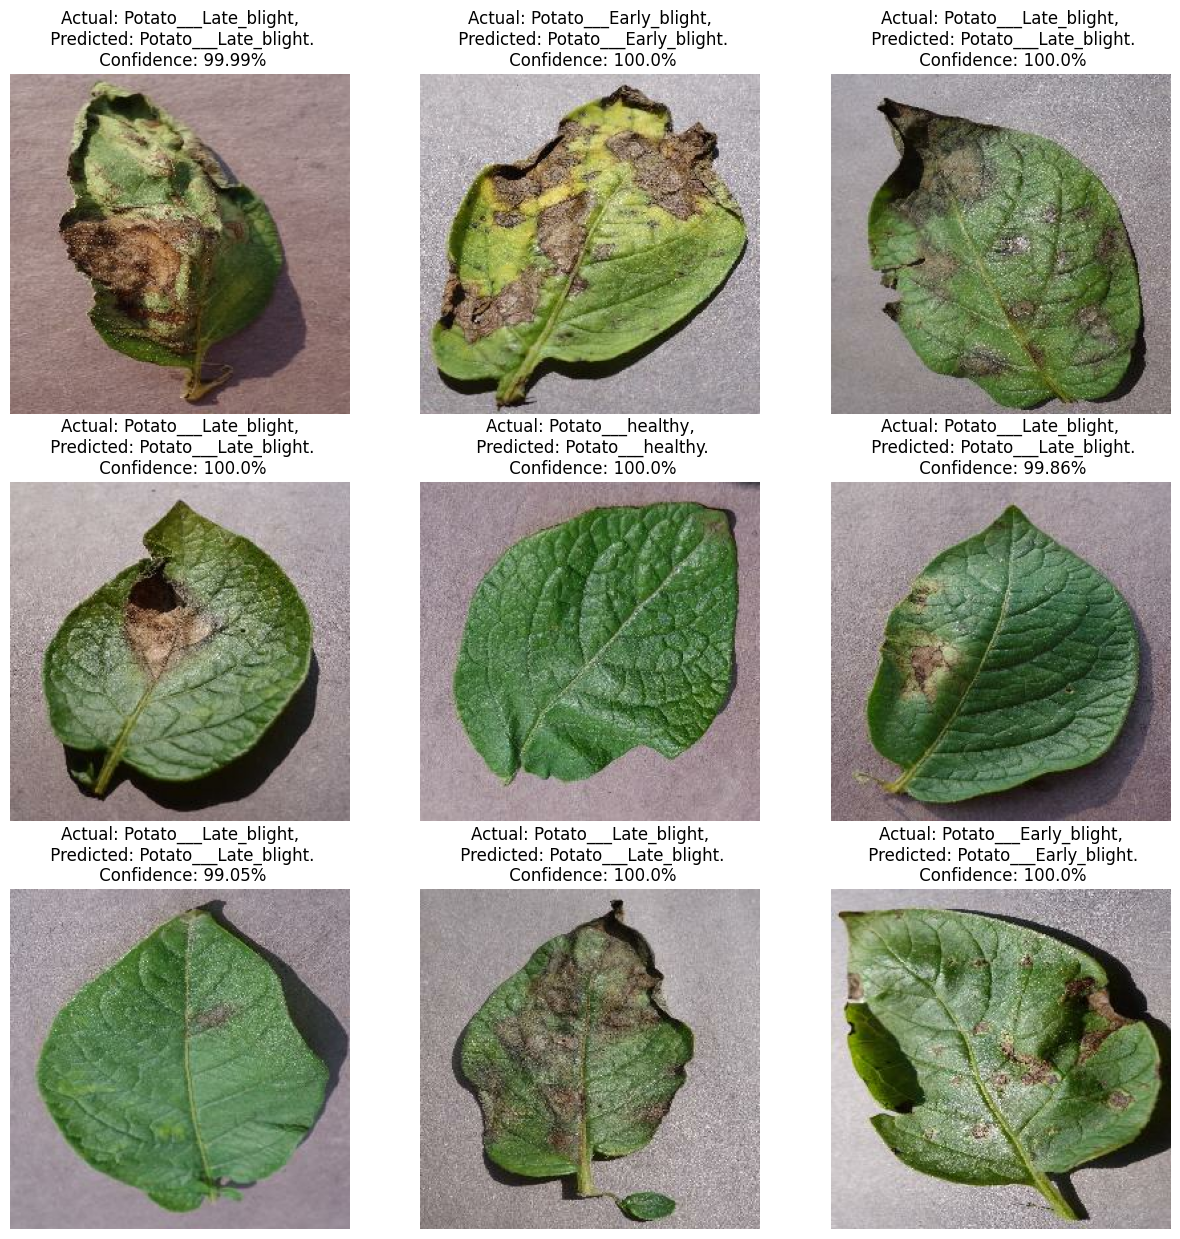

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
y_true = []
y_scores = []

for images_batch, labels_batch in test_ds:
    predictions = model.predict(images_batch)
    y_scores.extend(predictions)
    y_true.extend(labels_batch)

y_true = np.array(y_true)
y_scores = np.array(y_scores)

y_pred = np.argmax(y_scores, axis=1)

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print(report)

roc_score = roc_auc_score(y_true, y_scores, multi_class='ovr')
print("ROC AUC score:", roc_score)

1/1 [==============================] - 0s 41ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       110
 Potato___Late_blight       1.00      0.99      1.00       128
     Potato___healthy       0.95      1.00      0.97        18

             accuracy                           1.00       256
            macro avg       0.98      1.00      0.99       256
         weighted avg       1.00      1.00      1.00       256

ROC AUC score: 1.0
